This notebook goes through the steps of solving for network weights that take in state and a history of control signals encoded through an LDN, and predicts the LDN coefficients for the future theta window of time.

In [1]:
%%javascript
//Added to avoid scrollbars in cell outputs
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import nengo
import scipy.linalg
from scipy.special import legendre
import math

# Fix the numpy random seed for reproducible results
seed = 12
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']
# added so we can rotate 3d plots
#%matplotlib notebook

# ===== DEFINE SIM CONSTANTS =====
dt = 0.005
theta = 1
q = 4

**Generating signal to predict**

First we create an asymmetrical signal to encode with an LDN.

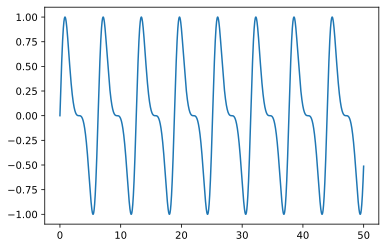

In [3]:
t = np.arange(0, 50, dt)
def yfn(t):
    return np.sin(t+np.sin(t))
y = yfn(t)
y = y[:, np.newaxis]
plt.figure()
plt.plot(t, y)
plt.show()

Next we define the LDN and the encoding/decoding processes.

In [4]:
class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices A and B so that
        #  dx/dt = Ax + Bu will convert u into a legendre representation over a window theta
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        A = np.zeros((q, q))
        B = np.zeros((q, 1))
        for i in range(q):
            B[i] = (-1.)**i * (2*i+1)
            for j in range(q):
                A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1))
        self.A = A / theta
        self.B = B / theta

        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre

    def get_weights_for_delays(self, r):
        # compute the weights needed to extract the value at time r
        # from the network (r=0 is right now, r=1 is theta seconds ago)
        r = np.asarray(r)
        m = np.asarray([legendre(i)(2*r - 1) for i in range(self.q)])
        return m.reshape(self.q, -1).T
    
    
def encode_ldn_data(theta, q, z, dt):
    model = nengo.Network()
    with model:
        ldn = nengo.Node(LDN(theta=theta, q=q, size_in=z.shape[1]), label='ldn')

        def in_func(t):
            return z[int(t/dt - dt)]

        in_node = nengo.Node(in_func, size_in=None, size_out=z.shape[1])

        nengo.Connection(in_node, ldn, synapse=None)
        Z = nengo.Probe(ldn, synapse=None)
    sim = nengo.Simulator(network=model, dt=dt)
    with sim:
        sim.run(z.shape[0]*dt)

    return sim.data[Z]


def decode_ldn_data(Z, q, theta, theta_p=None):
    """
    Parameters
    ----------
    Z: float array(steps, m*q)
        prediction of state Z in legendre domain
    q: int
        legendre dimensionality
    theta: float
        prediction horizon length [sec]
    theta_p: float array, Optional (Default: None)
        The times to extract from the legendre predictions
        if None, we will output the prediction at theta.
    """
    m = int(Z.shape[1]/q)
    if theta_p is None:
        theta_p = [theta]
    theta_p = np.asarray(theta_p)

    transform = LDN(theta=theta, q=q, size_in=1).get_weights_for_delays(theta_p/theta)
    zhat = []
    for _Z in Z:
        _Z = _Z.reshape((m, q)).T
        zhat.append(np.dot(transform, _Z))

    return np.asarray(zhat)

Next we encode the generated signal through an LDN

In [5]:
theta_p = [0, theta]
Y = encode_ldn_data(
    theta=theta,
    q=q,
    z=y,
    dt=dt
)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Test that if we decode our state out that it aligns as expected.

(10000, 2, 1)


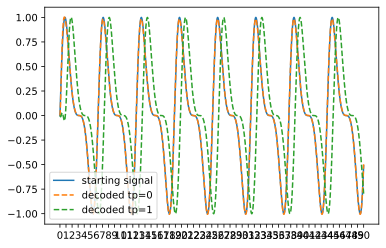

In [6]:
yhat = decode_ldn_data(
    Z=Y,
    q=q,
    theta=theta,
    theta_p=theta_p
)
print(yhat.shape)
plt.figure()
plt.plot(t, y, label='starting signal')
for jj, tp in enumerate(theta_p):
    plt.plot(t, yhat[:, jj, :], linestyle='--', label=f'decoded tp={tp}')
plt.legend()
plt.xticks(np.arange(min(t), max(t)+1, 1.0))
plt.show()

As expected, if we decode the value at theta_p/theta=0 it returns the signal at the current time. If we decode the value at theta_p/theta=1 it returns the signal from theta seconds in the past.

**LLP to learn the same coefficients shifted in time**

Now say that I want to get a network to take in the legendre polynomial coefficients at the current time, and learn to output the legendre coefficients from theta seconds in the future. These coefficients would effectively represent a window of theta seconds into the future


The goal is to ultimately learn this online with the LLP, but first to test the feasibility of a single layer learning this problem, the NEF method for decoder solving is used to solve for weights. This will see if a single layer of neurons is able to solve for the function. To obtain the required evaluation and function points, two different slices of the ldn encoded context signal are used.

First define theta_steps as the number of discrete steps that make up the window of length theta.
$${theta_{steps}=theta/dt}$$

For evaluation points, the legendre coefficients are taken in the range $[:-theta_{steps}]$.

For function points, the legendre coefficients are taken in the range $[theta_{steps}:]$.

This offsets the points so that the first evaluation point will be the current LDN coefficients, and the first function point will be the LDN coefficients theta seconds into the future.

**Decoding shifted legendre polynomial coefficients**

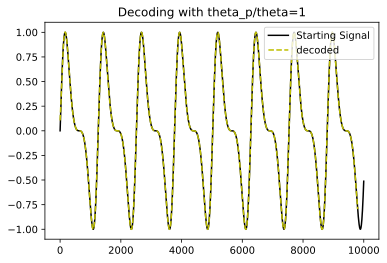

In [7]:
theta_p = [theta]
theta_steps = int(theta/dt)
eval_pts = Y[:-theta_steps]
func_pts = Y[theta_steps:]

func_decoded = decode_ldn_data(
    Z=func_pts,
    q=q,
    theta=theta,
    theta_p=theta_p
)

plt.figure()
plt.title("Decoding with theta_p/theta=1")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()
plt.show()

Note that when decoding the value at theta_p=theta the decoded value aligns with the current state. This is because of how the values were encoded. If we take the LDN coefficients that encode the state theta seconds in the future (t+theta) and use them at time t, then theta_p/theta=0 refers to time t+theta (which is the current time wrt to the LDN that encoded the signal theta seconds in the future). Likewise, theta_p/theta=1 will output the value at time t, because with respect to the future LDN, this would be the time theta seconds ago (t + theta - theta).

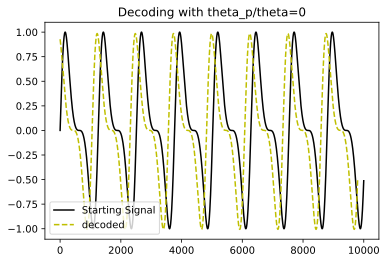

In [8]:
theta_p = [0]

func_decoded = decode_ldn_data(
    Z=func_pts,
    q=q,
    theta=theta,
    theta_p=theta_p
)

plt.figure()
plt.title("Decoding with theta_p/theta=0")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()
plt.show()

**Converting coefficients to LLP**

In contrast, when decoding coefficients from an LLP, theta_p/theta=1 would refer to the time theta seconds in the future. To get our "ground truth" coefficient from the shifted LDN to match, we can simply flip the signs of the odd coefficient indexes.

Create a small function for using the NEF decoder solver, and to optionally run the sim with those solved weights loaded in

(9800, 4)


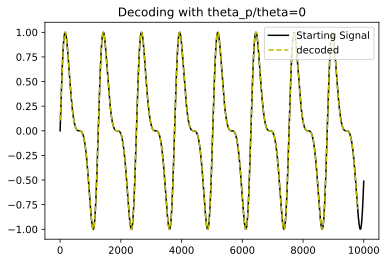

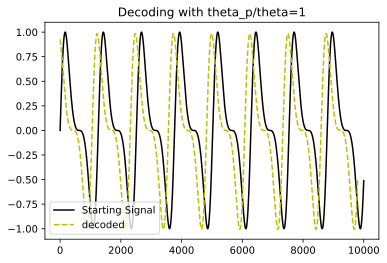

In [9]:
theta_p = [0]
print(func_pts.shape)
func_pts_llp = np.copy(func_pts)
for ii in range(0, func_pts.shape[1]):
    if ii%2 != 0:
        func_pts_llp[:, ii] *= -1
        
func_decoded = decode_ldn_data(
    Z=func_pts_llp,
    q=q,
    theta=theta,
    theta_p=theta_p
)

plt.figure()
plt.title("Decoding with theta_p/theta=0")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()

theta_p = [1]
func_decoded = decode_ldn_data(
    Z=func_pts_llp,
    q=q,
    theta=theta,
    theta_p=theta_p
)

plt.figure()
plt.title("Decoding with theta_p/theta=1")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()
plt.show()

In [10]:
def nef_decode(eval_pts, fnc_pts, dt, weights=None):
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(
            n_neurons=1000,
            dimensions=eval_pts.shape[1],
            neuron_type= nengo.RectifiedLinear(),
            radius=1,
            seed=0
        )
        pred = nengo.Node(size_in=fnc_pts.shape[1])
        if weights is None:
            conn = nengo.Connection(
                ens,
                pred,
                eval_points=eval_pts,
                function=fnc_pts,
                synapse=None
            )
        else:
            print('Testing with trained weights')
            conn = nengo.Connection(
                ens.neurons,
                pred,
                transform=weights,
                synapse=None
            )

            def in_func(t):
                return eval_pts[int((t-dt)/dt)]
            in_node = nengo.Node(in_func)

            nengo.Connection(in_node, ens, synapse=None)
            # probe output
            net_out = nengo.Probe(pred, synapse=None)


    sim = nengo.Simulator(model, dt=dt)
    with sim:
        if weights is None:
            eval_pt, tgt, decoded = nengo.utils.connection.eval_point_decoding(
                conn,
                sim
            )
        else:
            # NOTE eval function does not work on neur>post connection
            # eval_pt, tgt, decoded = nengo.utils.connection.eval_point_decoding(
            #     conn,
            #     sim,
            #     eval_points=c_state
            # )
            sim.run(eval_pts.shape[0]*dt)
            decoded = sim.data[net_out]

        weights = sim.signals[sim.model.sig[conn]["weights"]]

    return(decoded, weights)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

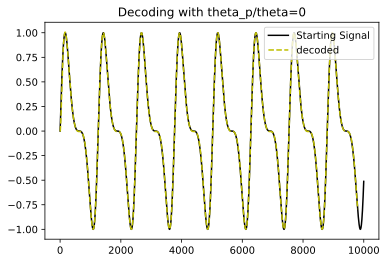

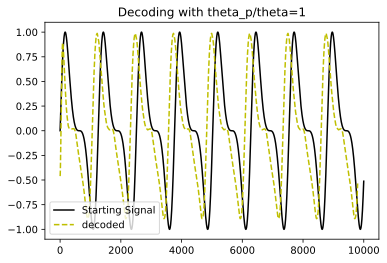

In [11]:
decoded, weights = nef_decode(
    eval_pts=eval_pts,
    fnc_pts=func_pts_llp,
    dt=dt,
    weights=None
)


func_decoded = decode_ldn_data(
    Z=decoded,
    q=q,
    theta=theta,
    theta_p=[0]
)

plt.figure()
plt.title("Decoding with theta_p/theta=0")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()

theta_p = [1]
func_decoded = decode_ldn_data(
    Z=decoded,
    q=q,
    theta=theta,
    theta_p=[1]
)

plt.figure()
plt.title("Decoding with theta_p/theta=1")
# ground truth recorded signal, skipping the first theta steps
plt.plot(y, label='Starting Signal', c='k')
#plt.plot(y[theta_steps:], label='Signal Shifted by Theta', c='r')
# squeeze decoded because returns with shape [steps, len(theta_p), dimensions]
plt.plot(np.squeeze(func_decoded), linestyle='--', label='decoded', c='y')
plt.legend()
plt.show()